<a href="https://colab.research.google.com/github/you444Mo/Python-Projects/blob/main/GB656_Week_5_Assignment_5_(Selecting_Rating_Model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hotel Ratings: Selecting Rating Model

NOTE: If attempting to run script top to bottom, I would recommend to comment out the stepwise Logistic model, as it took about 2 hours for the algorithm to complete it's iterations.

### **Initial Set-Up**

In [ ]:
### Install Needed Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc, mean_squared_error,mean_absolute_error, r2_score

In [ ]:
#pandas setting
pd.set_option('display.max_columns', None) ### always show me all columns
pd.set_option('display.max_rows', None) ### always show all rows
pd.set_option('display.float_format', '{:.2f}'.format) ### Turn off scientific notation (format float)

In [ ]:
! git clone https://github.com/danielbauer1979/MSDIA_PredictiveModelingAndMachineLearning.git

Cloning into 'MSDIA_PredictiveModelingAndMachineLearning'...
remote: Enumerating objects: 367, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 367 (delta 71), reused 15 (delta 15), pack-reused 253 (from 2)
Receiving objects: 100% (367/367), 49.94 MiB | 6.49 MiB/s, done.
Resolving deltas: 100% (182/182), done.
Updating files: 100% (82/82), done.


In [ ]:
### Read data into df
Reviews_DF = pd.read_csv('/content/MSDIA_PredictiveModelingAndMachineLearning/GB886_II_8_LasVegasTripAdvisorReviews.csv')

### View Data
Reviews_DF.head()

,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars
0,USA,11,4,13,5,Dec-Feb,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3
1,USA,119,21,75,3,Dec-Feb,Business,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3
2,USA,36,9,25,5,Mar-May,Families,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3
3,UK,14,7,14,4,Mar-May,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3
4,Canada,5,5,2,4,Mar-May,Solo,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3


In [ ]:
Reviews_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   User country       504 non-null    object
 1   Nr. reviews        504 non-null    int64 
 2   Nr. hotel reviews  504 non-null    int64 
 3   Helpful votes      504 non-null    int64 
 4   Score              504 non-null    int64 
 5   Period of stay     504 non-null    object
 6   Traveler type      504 non-null    object
 7   Pool               504 non-null    object
 8   Gym                504 non-null    object
 9   Tennis court       504 non-null    object
 10  Spa                504 non-null    object
 11  Casino             504 non-null    object
 12  Free internet      504 non-null    object
 13  Hotel name         504 non-null    object
 14  Hotel stars        504 non-null    int64 
dtypes: int64(5), object(10)
memory usage: 59.2+ KB


### **Preliminary Data Prep:**

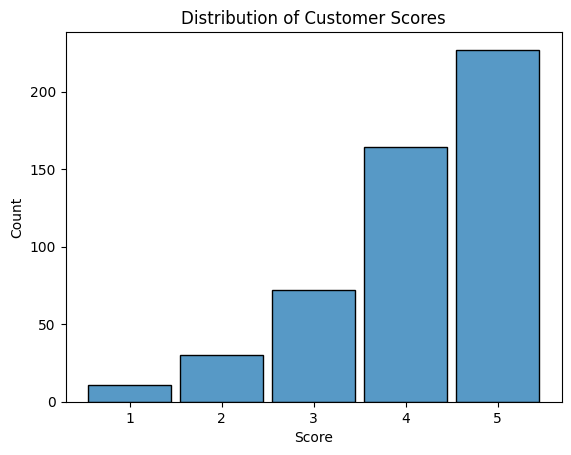

In [ ]:
### View Distriubtion of target variable: Score
sns.histplot(
    data = Reviews_DF,
    x = 'Score',
    stat = 'count',
    binwidth= 1, ### 1 bin for each score
    binrange= (np.min(Reviews_DF['Score']) - 0.5, np.max(Reviews_DF['Score']) + 0.5), ### Center each bar
    shrink = 0.9 ### Shrink each bar to allow space between
)

plt.title("Distribution of Customer Scores")

plt.show()

**<u>Notes:</u>**

The target variable, "Score" has 5 total classes (1-5), 1 being a bad review, 5 being a great review. With that being said, it is fair to say that the "Score" variable is ordinal, given that a score of 1 "ranks" much lower in terms of customer satisfication vs a score of 5. Also, notice the discrpency between the highest score, 5, and the lowest, 1 in terms of volume. We may try a resampling method after our inital modeling if we feel that the stepwise methods did not yield a suitable model.

Will attempt a backward stepwise regression method using OLS regression, and then will try a forward approach using ordinal logistic regression, and will then evaluate the optimal models chosen from both regression types to select the best model for predicting what score a customer will give a hotel.

I will keep most of the variables in the design matrixes for both models, and will allow the stepwise algorithm to select the best combos of them for the optimal model.

####**Feature Engineering**

In [ ]:
### Column mover function
def col_mover(df,col,loc):
  """
  Use this function to move columns
  around in a pandas dataframe.
  """
  column_to_move = df.pop(col)
  df.insert(loc,col,column_to_move)

In [ ]:
#### Set Target Variables for Linear/Logistic Regression
# Target Variable: Linear
Y_Lin = Reviews_DF['Score']
# Target Variable: Logistic (Ordinal)
Y_Log = Reviews_DF['Score']

In [ ]:
#### Create a Feature Matrix for both the Linear and Logistic Model
# Drop Target Variable and other unneeded features
X = Reviews_DF.drop(columns = ['Score','Hotel name'])
# Drop Uneeded Variables for modeling
# Select only Categorical Variables
X_Categ = X.select_dtypes(include = ['object'])
# Append Hotel Stars to Categorcial Var DF
X_Categ['Hotel stars'] = X['Hotel stars']
# Cast All Categorical Variaables as Dummy Variables
X_Dummies = pd.get_dummies(
    data = X_Categ.astype(object),
    dtype = int,
    drop_first = True
)

In [ ]:
### Append dummy fields to int variables in design matrix
# Make a copy out of the original Feature Matrix
X_Modeling = X.copy()
# Drop all Categorical Variables
X_Modeling.drop(columns = X_Categ, inplace = True)

# Append dummy variables to modeling Design Matrix
X_Modeling_Merged = pd.concat([X_Modeling,X_Dummies], axis = 1)

In [ ]:
### Create New Features
X_Modeling_Merged['Helpful Votes Ratio'] = X_Modeling_Merged['Helpful votes'] / X_Modeling_Merged['Nr. reviews']
X_Modeling_Merged['Hotel Review Ratio'] = X_Modeling_Merged['Nr. hotel reviews'] / X_Modeling_Merged['Nr. reviews']

### Move New Features to front end of the Feature Matrix
col_mover(X_Modeling_Merged,'Helpful Votes Ratio',3)
col_mover(X_Modeling_Merged,'Hotel Review Ratio',4)

# X_Modeling_Merged.head()

In [ ]:
### Scale Variables in DesignMatrix (Using Standard Scaler)
scaler = StandardScaler()
### Scale Data (DO NOT SCALE DUMMY VARIABLES)
X_Modeling_Scaled_Vars = scaler.fit_transform(X_Modeling_Merged[['Nr. reviews', 'Nr. hotel reviews', 'Helpful votes', 'Helpful Votes Ratio', 'Hotel Review Ratio']])
### Convert Scaled Vars from Numpy Array back to DF
X_Modeling_Scaled_Vars_DF = pd.DataFrame(X_Modeling_Scaled_Vars, columns = X_Modeling_Merged[['Nr. reviews', 'Nr. hotel reviews', 'Helpful votes', 'Helpful Votes Ratio', 'Hotel Review Ratio']].columns)
### Bring Scaled non-dummy data together with dummy data in one df
X_Modeling_Scaled_DF = pd.concat( ### Used in Ordinal Logit Model
    [
        X_Modeling_Scaled_Vars_DF, X_Modeling_Merged.drop(columns= ['Nr. reviews', 'Nr. hotel reviews', 'Helpful votes', 'Helpful Votes Ratio', 'Hotel Review Ratio'])
        ], axis = 1
    )

### Add Constant
X_Modeling_Const = sm.add_constant(X_Modeling_Scaled_DF) ### (Used in OLS Model only!)

X_Modeling_Const.head()

,const,Nr. reviews,Nr. hotel reviews,Helpful votes,Helpful Votes Ratio,Hotel Review Ratio,User country_Belgium,User country_Brazil,User country_Canada,User country_China,User country_Costa Rica,User country_Croatia,User country_Czech Republic,User country_Denmark,User country_Egypt,User country_Finland,User country_France,User country_Germany,User country_Greece,User country_Honduras,User country_Hungary,User country_India,User country_Iran,User country_Ireland,User country_Israel,User country_Italy,User country_Japan,User country_Jordan,User country_Kenya,User country_Kuwait,User country_Malaysia,User country_Mexico,User country_Netherlands,User country_New Zealand,User country_Norway,User country_Philippines,User country_Puerto Rico,User country_Saudi Arabia,User country_Singapore,User country_South Africa,User country_South Korea,User country_Spain,User country_Switzerland,User country_Syria,User country_Taiwan,User country_Thailand,User country_UK,User country_USA,User country_United Arab Emirates,Period of stay_Jun-Aug,Period of stay_Mar-May,Period of stay_Sep-Nov,Traveler type_Couples,Traveler type_Families,Traveler type_Friends,Traveler type_Solo,Pool_YES,Gym_YES,Tennis court_YES,Spa_YES,Casino_YES,Free internet_YES,Hotel stars_4,Hotel stars_5
0,1.00,-0.50,-0.50,-0.39,0.33,-0.20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0
1,1.00,0.95,0.21,0.89,-0.26,-0.60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0
2,1.00,-0.16,-0.29,-0.14,-0.19,-0.45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0
3,1.00,-0.46,-0.38,-0.37,0.13,0.09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0
4,1.00,-0.58,-0.46,-0.61,-0.51,1.16,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,0


### **Initial Model Builds:**

#### **Multiple Linear Model:**

In [ ]:
### Fit OLS Model
Review_OLS = sm.OLS(Y_Lin,X_Modeling_Const).fit()
### Show Summary Results
print(Review_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     2.425
Date:                Tue, 04 Nov 2025   Prob (F-statistic):           9.20e-08
Time:                        18:53:21   Log-Likelihood:                -643.22
No. Observations:                 504   AIC:                             1414.
Df Residuals:                     440   BIC:                             1685.
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

##### **<u>Interpretations:</u>**

Standard Scaling was utilized across all features to mitigate model bias towards variables of larger scales vs others (ie: Dummy variables (scale 1,0) vs Nr. reviews (scaled in the 100s).

**<u>Key Model Stats:</u>**

* Model R^2: 0.258
* Skew: -0.996
* Kurtosis: 4.008
* JB: 104
* AIC: 1414
* Log-Likelihood: -643.22

Just from viewing the Skew, Kurtosis, and JB value alone, we can see that OLS regression may not be the best fit for this specific dataset, as the error terms don't seem to be distributed normally.

However, we do get some interesting insights from our coefficents:

* **Nr. reviews** is statistically significant, with a coeff of -0.2751. Since we scaled all of our features, this can be interpreted as "for every 1 standard deviation change in the number of reviews, the expected value for the User Score decreases by -0.2751."
* The **Helpful Votes** variable has a statistically significant, positive association with score (coeff of 0.3244).
* The **Helpful Votes Ratio** feature that we created based off the number of helpful votes and total reviews also appears to be statistically significant, but with a negative association, (coefficient of -0.2934), telling us that "for every 1 standard deviation change in the rate of Helpful votes to Total Reviews,the expected vlaue for the User score decreases by -0.2934. This further highlights the negative association that "Nr Reviews" has with Score.
* Interstingly, none of the User Country Features seem to have a statistically significant association with Score
* Some of the other features, such as traveler type(s), amenties (pool, spa, casino), hotel start rating, etc... all have some type of statistically significant association with Score.

**Model Evaluation:**

In [ ]:
### Store Predictions
y_pred_linear = Review_OLS.predict(X_Modeling_Const.astype(float))

In [ ]:
### Preditions
y_pred_linear_rounded = np.round(y_pred_linear).astype(int)
# Ensure predictions are within valid range (0-4)
y_pred_linear_rounded = np.clip(y_pred_linear_rounded, 1, 5) ### Rounds predicted values out, ensures that we only look at values from 1 - 5, as integers

# Generate confusion matrix
cm_linear = confusion_matrix(Y_Lin, y_pred_linear_rounded)
print(cm_linear)

# Calculate misclassification rate
misclassification_rate_linear = 1 - np.diag(cm_linear).sum() / cm_linear.sum()
print(misclassification_rate_linear)

[[  1   2   3   5   0]
 [  0   3   7  20   0]
 [  0   0  17  51   4]
 [  0   1  13 122  28]
 [  0   0   2 155  70]]
0.5773809523809523


We see that the misclassifcation rate for the linear model sits at about 57.74%

In [ ]:
### Goodness of fit/Error Metrics
MSE = mean_squared_error(Y_Lin,y_pred_linear)
MAE = mean_absolute_error(Y_Lin,y_pred_linear)
R2 = r2_score(Y_Lin,y_pred_linear)

print(f"MSE: {MSE}")
print(f"MAE: {MAE}")
print(f"R-squared: {R2}")

MSE: 0.7516934175313152
MAE: 0.6766886353856425
R-squared: 0.25769296053448865


If we go the OLS route, we want a model that minimizes MSE/Maximizes R^2, while also avoiding overfitting.

#### **Ordinal Logistic Regression:**

Due to the ordinal properties of the "Score Variable" that we discussed earlier and for our need to predict user scores, an Ordinal Logistic Regression approach will now be fitted on the data to see if we can get more quality predictions for Guest Scores.

<u>**Overall assumptions for Ordinal Logistic Regression:**</u>

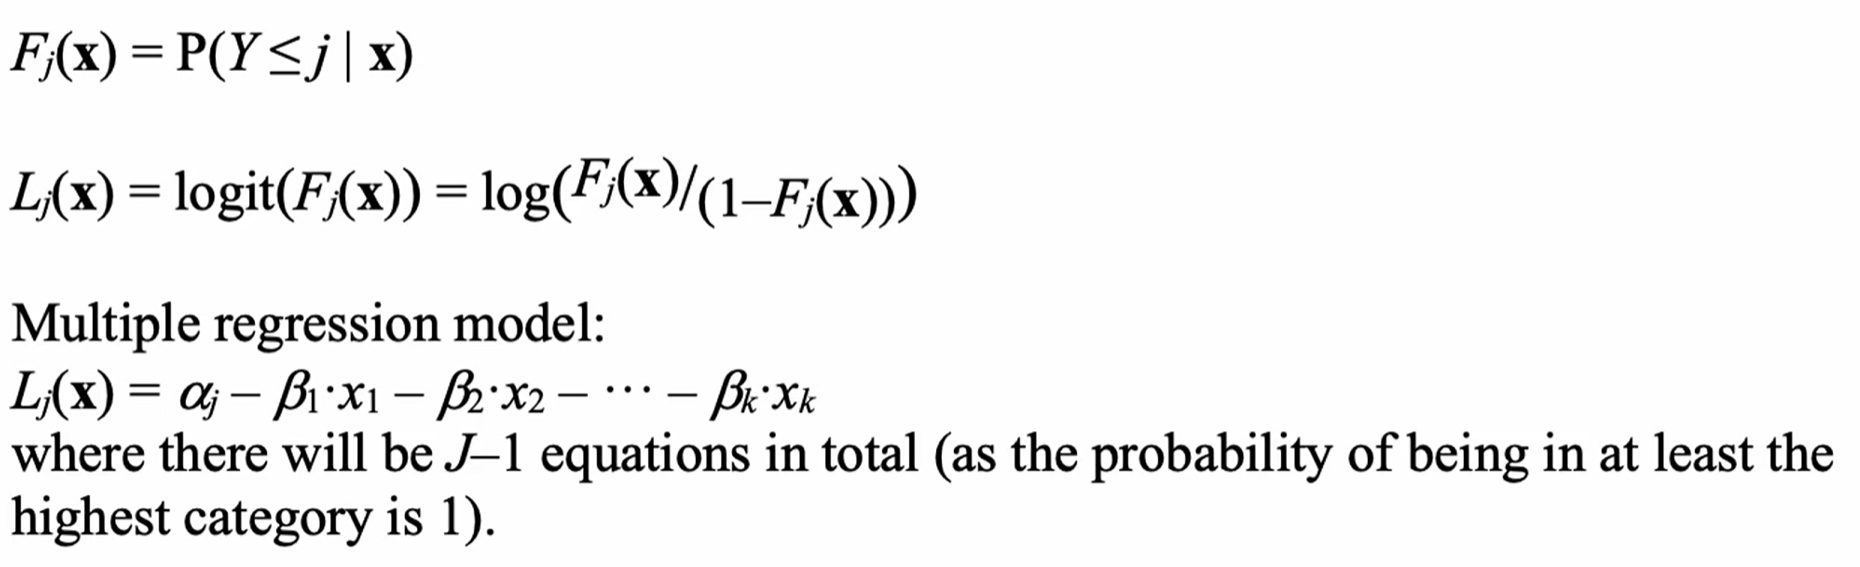

Ordinal regression requires us to think about cumulative probabilities instead of individual category probabilites (in terms of when we plug in the log odds calcs into the logistic function). We assume that when we make it up to the lowest category in particular (in our case: a score of 1,), we will know the probability of a guest falling into that category. When we arrive at 2, and eventually 3,4, and 5, we will know the cumulative probability of a guest being at that particular score threshold or below. Essentially, per each observation, the model will generate cumulative probabilities of that guest falling into each of the categories (scores 1-5), and then the objective is to select the highest of the 5 individully calculated probabilities, the related score is then recorded as the projected guest score. To get the probabilites for each individual category, we take a score, and then we simply subtract out the cumulative probabilities of the scores below it from it's own cumulative probability. Each obs will have j - 1 equations, as the probabilitiy of someone giving a score of at least 5 is 100%, so there's no individual "model" that needs to be run for that scenario. The model in general is essentially calculating the cumulative probability of making it to each categorical threshold per observation.  

In [ ]:
#### Create Ordinal Model
Reviews_Log = OrderedModel(
    Y_Log, X_Modeling_Scaled_DF, distr="logit" ### Ordinal Models do not accept Constants
)

### Fit model and show summary
res_log = Reviews_Log.fit(method="bfgs", disp=False) ### fit on a log link function
print(res_log.summary()) ### print model summary

                             OrderedModel Results                             
Dep. Variable:                  Score   Log-Likelihood:                -559.70
Model:                   OrderedModel   AIC:                             1253.
Method:            Maximum Likelihood   BIC:                             1536.
Date:                Tue, 04 Nov 2025                                         
Time:                        18:53:36                                         
No. Observations:                 504                                         
Df Residuals:                     437                                         
Df Model:                          63                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Nr. reviews                          -0.6639      0.186     -3.573      0.000      -1

##### **<u>Interpretations:</u>**

<u>Intercepts</u>:
* 1/2: 0.3960
* 2/3: 0.4876
* 3/4: 0.3498
* 4/5: 0.5791

<u>Model KPIs</u>:
* AIC: 1253
* Log-Likelihood: -559.70

The intercepts are used in their related models (based on the score value being looked at) to calculate their associated cumulative probabilities (ie, the cumulative probability of a guest leaving a score of at or below 2). Each intercept value represents the logodds of a score being at or below that certain threshold category when all predictors are at 0. For each combo of Model/score, the linear combos (logodds * x) of each feature are subtracted from the intercept of the threshold that is being observed. The result of the logistic function is a cumulative probability of someone giving a score at or below the observed threshold.
<br>
<br>
In terms of the model KPIs, we see a Lower AIC and higher Log-Likelihood value vs the OLS model. Since this specific model is ordinal in nature, it's not an apples to apples comparison in terms of the values, but, nonetheless our objective is to still attain the lowest possible AIC while maximizing our Log-Likelihood estimation to attain the most accurate predictions to couple with the least amount of variance and an optimal amount of features.
<br>
<br>

The coefficients in this model are interpreted vary similary to nominal logistic regression:

* The Coeff. for **Nr. reviews** is -0.6639. This can be interpreted as "for every 1 standard deviation change in the number of reviews a user writes, the log odds of a review recieving a higher score (vs a lower one) decreases by -0.6639. In terms of odds, when taking e^-0.6639, we get 0.5148, taking 1 - 0.5148, we see that the odds for a user giving a high score in their review decreases by 48.52% for every standard deviation change in the number of reviews' they've written.

* Coeff for Helpful Votes Ratio: -0.5565. This is interpreted as: "for every 1 standard deviation change in the ratio of helpful votes recieved to total user reviews written by a user, the log odds of a review recieving a higher score decreases by -0.5565. In terms of odds, 1 - e^-0.5565 = 42.68%, meaning that the odds of a user giving a higher score in their review decreases by 42.68% for every standard deviation change in the helpful votes ratio.

* When looking at the interpretation of the dummy variables that are statistically significant, we see for instance with "casino_yes" (beta coeff:  1.2213) that when a property has a casino, all else held equal, the log odds of a user giving a high score increases by 1.2213. In terms of odds, e^1.2213 = 3.39, meaning that someone is 3.39x more likely to give a higher score given that a property has a casino.

**Model Evaluation:**

In [ ]:
### Store model Precitions in array
predicted = res_log.model.predict(
    res_log.params, exog= X_Modeling_Scaled_DF
)
predicted

### We see in the predictions, that 5 cumulative probabilities are generated per observation (person), one for each score threshold (1-5)

array([[0.04387946, 0.14564911, 0.30188828, 0.36055476, 0.1480284 ],
       [0.08873167, 0.24289009, 0.3405185 , 0.25216727, 0.07569247],
       [0.08303882, 0.2327062 , 0.34021561, 0.26311324, 0.08092613],
       ...,
       [0.02848909, 0.10150965, 0.25172704, 0.40448855, 0.21378567],
       [0.01766865, 0.06628706, 0.19071855, 0.41816995, 0.30715579],
       [0.06911951, 0.20537595, 0.33538451, 0.29314465, 0.09697537]])

In [ ]:
### View Total Models ran on data
count = 0
for obs in predicted:
  for prob in obs:
    count = count + 1

print(f"total models ran on data: {count}")

In [ ]:
### Matrix of predicted values for Y
pred_choice = predicted.argmax(axis=1) + 1 ### Provides the index of the highest of the probabilities between all 5 predicted classes per each observation (basically, takes the most likely out of the 5)
### Matrix of True values for Y  ### + 1 is to calibrate the indexing to start at 1 (given that scores range from 1 - 5, not 0 - 4)
y_true = Y_Log

In [ ]:
### Show Accuracy and Misclassification Rate
accuracy = (pred_choice == y_true.values).mean() ### Take the average rate in which the prediction matched the true score given by the individual
misclass_rate = 1 - accuracy ### Show the misclassifcation Rate

print(f"Accuracy: {accuracy:.3f}")
print(f"Misclassification rate: {misclass_rate:.3f}")

Accuracy: 0.563
Misclassification rate: 0.437


**<u>Notes:</u>**

Overall, 5 cumulative probability values are assigned per each guest (1 per each score threshold), we select the largest of the probabilites, and the index position of that probability + 1 is the score that the model predicts to be the most likely for that person to give.

From observing the misclassification rate, we can see that the Ordinal Logistic Model does a much better job of predicting what scores a guest will leave for a property vs the OLS Model.

Next, we will perfrom a Backward Stepwise optimization alogorthim in order to the find the combination of features that minimizes their AIC scores.

### **Step-wise Regression:**

#### **OLS Model (Backwards Approach):**

In [ ]:
remaining_features = list(X_Modeling_Const.columns[1:]) ### excludes the constant
selected_features = remaining_features.copy() ### Starts with the full model
model_sequence = []
aic_values = []

while remaining_features:
  best_aic = float('inf')
  best_feature = None
  best_model = None

  x_current = X_Modeling_Const[selected_features]
  x_current = sm.add_constant(x_current)
  current_model = sm.OLS(Y_Lin,x_current).fit()
  current_aic = current_model.aic  ### Generate current model AIC for comparison usage, later

  for feature in remaining_features: ### Iterate through each feature
    candidate_features = selected_features.copy()
    candidate_features.remove(feature) ### Remove features as we go

    X_candidate = X_Modeling_Const[candidate_features]
    X_candidate = sm.add_constant(X_candidate)
    candidate_model = sm.OLS(Y_Lin,X_candidate).fit()
    candidate_aic = candidate_model.aic

    if candidate_aic < best_aic: ### if candidate aic is greater than the best aic
      best_aic = candidate_aic ### set the best aic equal to that candidates best aic
      worst_feature = feature ### saves the feature to the worst feature variable
      best_model = candidate_model ### saves the model in the iteratio to the best_model variable

  if best_aic >= current_aic: ### if the best model aic is greater than or equal to the current aic
    break # Stop if removing any feature increases AIC

  selected_features.remove(worst_feature) ### Remove the worst features 1 by 1
  remaining_features.remove(worst_feature) ### remove from the remaining features list so we don't keep iterating through them
  model_sequence.append(best_model) ### append full sequence of models gone through
  aic_values.append(best_aic) ### append all AIC values

# The last model in the sequence is best
best_model = model_sequence[-1] ### grab the model at the end of the model list
print(best_model.summary())
print(f"\n The best AIC vlaue is: {np.min(aic_values)}")




                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     6.877
Date:                Tue, 04 Nov 2025   Prob (F-statistic):           7.20e-17
Time:                        22:42:17   Log-Likelihood:                -655.17
No. Observations:                 504   AIC:                             1352.
Df Residuals:                     483   BIC:                             1441.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [ ]:
### Show total Models the stepwise alogrithm iterated through
count = 0
for i in model_sequence:
  count += 1

print(f"\nTotal Models Iterated Through: {count}")


Total Models Iterated Through: 43


In [ ]:
### Store Predictions
y_pred_linearstepwise = best_model.predict(sm.add_constant(X_Modeling_Const[selected_features]).astype(float))

In [ ]:
### Predictions
y_pred_linearstepwise_rounded = np.round(y_pred_linearstepwise).astype(int)
# Ensure predictions are within valid range (0-4)
y_pred_linearstepwise_rounded = np.clip(y_pred_linearstepwise_rounded, 1, 5) ### Rounds predicted values out, ensures that we only look at values from 1 - 5, as integers

# Generate confusion matrix
cm_linearstepwise = confusion_matrix(Y_Lin, y_pred_linearstepwise_rounded)
print(cm_linearstepwise)

# Calculate misclassification rate
misclassification_rate_linearStepwise = 1 - np.diag(cm_linearstepwise).sum() / cm_linearstepwise.sum()
print(f"Misclassification Rate: {misclassification_rate_linearStepwise}")

[[  1   1   3   6   0]
 [  0   2   9  18   1]
 [  0   0  13  56   3]
 [  0   0  16 117  31]
 [  0   0   4 158  65]]
Misclassification Rate: 0.6071428571428572


##### **<u>Model Notes</u>:**
We see that with the OLS model, the Backwards-Stepwise algorithm was able to find an optimal model that eliminates 43 of the 63 features, leaving the model with 20 of the features that presumably yields the Lowest AIC estimate. Notice how only a few of the user country fields were retained. The "hotel review ratio" was eliminated in the process as well.

This optimal model provides us with an AIC of 1352, compared to that of 1414 from the base model, a sizeable improvement over the base.

We also see that the misclassifed rate actually got worse (60.7% from 57% in the base model). This is not unexpected, as we used the training data for the purpose of optimization.

#### **Ordinal Logistic Model (Forward Approach):**


We are using a forward approach here for the sake of performance. Since ordinal regression runs 5 models per each observation in the data, the backwards approach (starting with all features) would take many hours to complete because of its more complex starting point.

In [ ]:
remaining_features_log = list(X_Modeling_Const.columns[1:]) ### excludes the constant
selected_features_log = [] ### Starts with no features
model_sequence_log = []
aic_values_log = []

while remaining_features_log:
  best_aic_log = float('inf')
  best_feature_log = None
  best_model_log = None

  for feature in remaining_features_log: ### Iterate through each feature in remaining features list
      candidate_features_log = selected_features_log + [feature]
      x_candidate_log = X_Modeling_Scaled_DF[candidate_features_log]
      candidate_model_log = OrderedModel(Y_Log, x_candidate_log, distr="logit") ### Ordinal Models do not accept Constants
      candidate_log_fitted = candidate_model_log.fit(method="bfgs", disp=False) ### fit on a log link function
      candidate_aic_log = candidate_log_fitted.aic ### Generate current model AIC for comparison usage, later

      if candidate_aic_log < best_aic_log: ### Want smallest AIC (Want least amount of Variance while tolerating some amount of bias)
          best_aic_log = candidate_aic_log ### will update the "best_aic variable as we find better feature combos"
          best_feature_log = feature ### adding in the best feature as we find them (that satisfies the aic condition above)
          best_model_log = candidate_model_log ### Will provide the best model based on the AIC

  selected_features_log.append(best_feature_log) ### append best features to selected features list
  remaining_features_log.remove(best_feature_log) ### remove best_features from the "remaining_features" list, as we don't want to double count them as we iterate
  model_sequence_log.append(best_model_log) ### append each model ran to best_model list
  aic_values_log.append(best_aic_log) ### append all AIC values generated per each model to list


# # Find the model with the lowest AIC
# best_model_index_log = np.argmin(aic_values_log) ### Find the index position of the smallest value in the aic_values list
# best_model_log = model_sequence[best_model_index_log] ### using the index position of the smalles AIC value, slice the model_sequence list to only provide the best model

# # Print the summary of the best model
# print(best_model_log.summary())
# print(f"\n The best AIC value is :{np.min(aic_values_log)}")

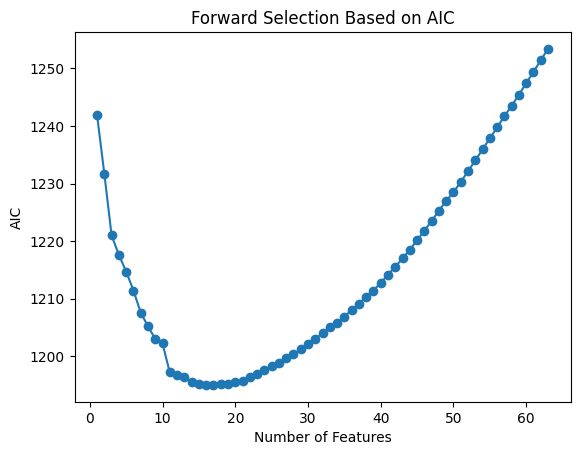

In [ ]:
# Plot AIC values against number of features
plt.plot(range(1, len(aic_values_log) + 1), aic_values_log, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('AIC')
plt.title('Forward Selection Based on AIC')
plt.show()

In [ ]:
#### print the model using the best features
# Find index of best AIC
best_model_index_log = np.argmin(aic_values_log)

# Select the features up to that step (index is 0-based, so add 1)
best_features_log = selected_features_log[:best_model_index_log + 1]

# Refit the model once on those best features
best_model_final = OrderedModel(Y_Log, X_Modeling_Scaled_DF[best_features_log], distr="logit")
best_model_fitted_final = best_model_final.fit(method="bfgs", disp=False)

# Show summary
print(best_model_fitted_final.summary())
print(f"\nThe best AIC value is: {aic_values_log[best_model_index_log]}")
print(f"\nNumber of selected features: {len(best_features_log)}")

                             OrderedModel Results                             
Dep. Variable:                  Score   Log-Likelihood:                -576.49
Model:                   OrderedModel   AIC:                             1195.
Method:            Maximum Likelihood   BIC:                             1284.
Date:                Wed, 05 Nov 2025                                         
Time:                        03:04:31                                         
No. Observations:                 504                                         
Df Residuals:                     483                                         
Df Model:                          17                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Hotel stars_5                1.2457      0.225      5.548      0.000       0.806       1.686
Pool_YES  

In [ ]:
### Store model Precitions in array
predicted_log_stepwise = best_model_fitted_final.model.predict(
    best_model_fitted_final.params, exog= X_Modeling_Scaled_DF[best_features_log]
)
predicted_log_stepwise

### We see in the predictions, that 5 cumulative probabilities are generated per observation (person), one for each score threshold (1-5)

array([[0.05620178, 0.16388865, 0.30229747, 0.33546618, 0.14214591],
       [0.09564176, 0.23821526, 0.32629225, 0.25451219, 0.08533854],
       [0.08829365, 0.22627947, 0.32555626, 0.26740497, 0.09246566],
       ...,
       [0.02771992, 0.09130796, 0.22465669, 0.3992068 , 0.25710862],
       [0.02761541, 0.09100572, 0.22418772, 0.39933983, 0.25785131],
       [0.08550114, 0.22153294, 0.32494789, 0.27255614, 0.09546189]])

In [ ]:
### Matrix of predicted values for Y
pred_choice_log = predicted_log_stepwise.argmax(axis=1) + 1 ### Provides the index of the highest of the probabilities between all 5 predicted classes per each observation (basically, takes the most likely out of the 5)
### Matrix of True values for Y  ### + 1 is to calibrate the indexing to start at 1 (given that scores range from 1 - 5, not 0 - 4)
y_true = Y_Log

In [ ]:
### Show Accuracy and Misclassification Rate
accuracy_log_stepwise = (pred_choice_log == y_true.values).mean() ### Take the average rate in which the prediction matched the true score given by the individual
misclass_rate_log_stepwise = 1 - accuracy_log_stepwise ### Show the misclassifcation Rate

print(f"Accuracy: {accuracy_log_stepwise:.3f}")
print(f"Misclassification rate: {misclass_rate_log_stepwise:.3f}")

Accuracy: 0.516
Misclassification rate: 0.484


##### **Model Notes:**

After running a forward stepwise algorithm on the ordinal logistic regression from earlier, we attain an optimal AIC value of 1195, which beats the base model's AIC (1253). The number of features used in the optimal model was also reduced from 63 to 17, which interestingly is close to the OLS variant of this algo (20).

The model's accuracy after optimization sits at 51.6%, with a misclassification rate of 48.4%. These are slight dips vs the base model (56.3% and 43.7%), but again, running this process using the same data that the model was trained on is usually the culprit.

### Final Notes:

Overall, I would choose the Ordinal Logistic Model over OLS regression, as it provided better results in terms of the accuracy and misclassification rates. We can also assume that when done with unseen testing data, the stepwise results would improve for both the OLS and Logistic models in terms of AIC score and model accuracy rates, but will still favor the Ordinal Logistic Regression.